In [1]:
import zipfile
import tarfile
import gzip
import requests
import os

In [2]:
def download_file(url, save_path):
    # Send a request
    response = requests.get(url, stream=True)
    # Check the response status code
    if response.status_code == 200:
        # Open the file in binary write mode
        with open(save_path, 'wb') as f:
            # Write the file chunk by chunk
            for chunk in response.iter_content(chunk_size=128):
                f.write(chunk)
        print("File downloaded successfully")
    else:
        print("Download failed. Status code:", response.status_code)

def extract_tar(file_path, extract_path):
    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"File '{file_path}' does not exist")
        return

    # Extract .tar file
    with tarfile.open(file_path, 'r') as tar:
        tar.extractall(path=extract_path)
    print(f"Extracted '{file_path}' to '{extract_path}'")

def extract_tar_gz(file_path, extract_path):
    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"File '{file_path}' does not exist")
        return

    # Extract .tar.gz file
    with gzip.open(file_path, 'rb') as gz:
        with tarfile.open(fileobj=gz, mode='r') as tar:
            tar.extractall(path=extract_path)
    print(f"Extracted '{file_path}' to '{extract_path}'")

In [3]:
caltech101_url = 'https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip?download=1'
download_path = '/content/downloads'
caltech101_path = download_path + '/caltech-101.zip'

if not os.path.exists(download_path):
  os.makedirs(download_path)

download_file(caltech101_url, caltech101_path)

File downloaded successfully


In [4]:
extract_path = download_path + '/extract'
if not os.path.exists(extract_path):
  os.makedirs(extract_path)
with zipfile.ZipFile(caltech101_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)

In [5]:
dataset_path = '/content/data'
if not os.path.exists(dataset_path):
  os.makedirs(dataset_path)

#label_path = dataset_path + '/label'
#image_path = dataset_path + '/image'

#extract_tar(extract_path + '/caltech-101/Annotations.tar', label_path)
#extract_tar_gz(extract_path + '/caltech-101/101_ObjectCategories.tar.gz', image_path)
extract_tar_gz(extract_path + '/caltech-101/101_ObjectCategories.tar.gz', dataset_path)

Extracted '/content/downloads/extract/caltech-101/101_ObjectCategories.tar.gz' to '/content/data'


In [6]:
image_path = dataset_path + '/101_ObjectCategories'

label_list = os.listdir(image_path)
label_list = [item for item in label_list if item!='BACKGROUND_Google']
label_path = [image_path + '/' + item for item in label_list]

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from PIL import Image

In [8]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("device=cuda")
else:
    device = torch.device("cpu")
    print("device=cpu")

device=cuda


In [9]:
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])]
    )

In [10]:
images = []
labels = []

for i in range(len(label_path)):
  folder_path = label_path[i]
#for folder_path in label_path:
  for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    #print(file_path)
    if filename.endswith('.jpg') or filename.endswith('.jpeg'):
      img = Image.open(file_path)
      if img.mode != 'RGB':
        img = img.convert('RGB')
      img_transformed = transform(img)
      images.append(img_transformed)
      labels.append(i)
    
labels = torch.tensor(labels)
train_data, test_data, train_targets, test_targets = train_test_split(images, labels, test_size=0.2, random_state=42)

In [11]:
class ConvNetDataset(Dataset):
  def __init__(self, data, targets, device, mask=1):
    self.data = data
    self.targets = targets
    if type(mask) != int:
        for i in range(len(self.data)):
            self.data[i] = self.data[i] * mask[i]

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    data = self.data[idx].to(device).to(device)
    targets = self.targets[idx].to(device)
    return data, targets

In [12]:
def model_test(model, testloader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = resnet18(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    model.train()
    return correct / total

In [13]:
# prob = 0
# train_mask = torch.bernoulli(torch.full(torch.Size([len(train_data)]) + train_data[0].shape[1:], 1 - float(prob)))
# test_mask = torch.bernoulli(torch.full(torch.Size([len(test_data)]) + test_data[0].shape[1:], 1 - float(prob)))

batch_size = 64
trainset = ConvNetDataset(train_data, train_targets, device)
testset = ConvNetDataset(test_data, test_targets, device)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)

In [14]:
class ResBlock(nn.Module):
    def __init__(self, channels, kernel_size=3, double_channels=False):
        super(ResBlock, self).__init__()
        if double_channels:
            self.conv1 = nn.Conv2d(channels // 2, channels, kernel_size=kernel_size, stride=2, padding=kernel_size // 2)
            self.conv2 = nn.Conv2d(channels, channels, kernel_size=kernel_size, stride=1, padding='same')
            self.res = nn.Conv2d(channels // 2, channels, kernel_size=1, stride=2, padding=0)
        else:
            self.conv1 = nn.Conv2d(channels, channels, kernel_size=kernel_size, stride=1, padding='same')
            self.conv2 = nn.Conv2d(channels, channels, kernel_size=kernel_size, stride=1, padding='same')
            self.res = nn.Identity()
            
        self.bn1 = nn.BatchNorm2d(channels)
        self.bn2 = nn.BatchNorm2d(channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.relu2 = nn.ReLU(inplace=True)
        
        self.layer = nn.Sequential(self.conv1, self.bn1, self.relu1, self.conv2, self.bn2)
    
    def forward(self, x):
        res = self.res(x)
        x = self.layer(x)
        x = x + res
        x = self.relu2(x)
        return x

In [15]:
net = nn.MaxPool2d(3, 2, 1)

In [16]:
class Resnet18(nn.Module):
    def __init__(self):
        super(Resnet18, self).__init__()
        layers = []
        layers.append(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3))
        layers.append(nn.BatchNorm2d(64))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.MaxPool2d(3, 2, 1))
        layers.append(ResBlock(64, 3))
        layers.append(ResBlock(64, 3))
        layers.append(ResBlock(128, 3, True))
        layers.append(ResBlock(128, 3))
        layers.append(ResBlock(256, 3, True))
        layers.append(ResBlock(256, 3))
        layers.append(ResBlock(512, 3, True))
        layers.append(ResBlock(512, 3))
        layers.append(nn.AdaptiveAvgPool2d(1))
        layers.append(nn.Flatten())
        layers.append(nn.Linear(512, 101))
        self.layer = nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.layer(x)
        return x

In [17]:
# net = Resnet18()
# x = torch.randn(16, 3, 224, 224)
# y = net(x)
# y.shape

In [18]:
resnet18 = Resnet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)

In [19]:
acc = []

#for epoch in tqdm(range(50)):
for epoch in tqdm(range(50)):
    if epoch==25:
        optimizer = optim.Adam(resnet18.parameters(), lr=0.0001)
    running_loss = 0.0
    for i, data in enumerate(trainloader):

      inputs, labels = data
      optimizer.zero_grad()

      outputs = resnet18(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      if i % 20 == 19:
          print('[%d, %5d] loss: %.5f' %
                (epoch + 1, i + 1, running_loss / 20))
          running_loss = 0.0

    acc.append(model_test(resnet18, testloader))
    print('acc: %.3f' % acc[epoch])
print('Finished Training')
acc.append(model_test(resnet18, testloader))


  0%|          | 0/50 [00:00<?, ?it/s]

[1,    20] loss: 4.26714
[1,    40] loss: 3.67311
[1,    60] loss: 3.58925
[1,    80] loss: 3.43104
[1,   100] loss: 3.35637


  2%|▏         | 1/50 [00:14<12:14, 14.99s/it]

acc: 0.236
[2,    20] loss: 3.18232
[2,    40] loss: 3.20638
[2,    60] loss: 3.12531
[2,    80] loss: 3.08241
[2,   100] loss: 2.94116


  4%|▍         | 2/50 [00:28<11:26, 14.30s/it]

acc: 0.332
[3,    20] loss: 2.79539
[3,    40] loss: 2.77903
[3,    60] loss: 2.67805
[3,    80] loss: 2.81549
[3,   100] loss: 2.73911


  6%|▌         | 3/50 [00:42<11:01, 14.08s/it]

acc: 0.411
[4,    20] loss: 2.51637
[4,    40] loss: 2.50212
[4,    60] loss: 2.40602
[4,    80] loss: 2.32936
[4,   100] loss: 2.37586


  8%|▊         | 4/50 [00:56<10:43, 13.99s/it]

acc: 0.442
[5,    20] loss: 2.14281
[5,    40] loss: 2.09727
[5,    60] loss: 2.14241
[5,    80] loss: 2.05697
[5,   100] loss: 1.92129


 10%|█         | 5/50 [01:10<10:27, 13.95s/it]

acc: 0.454
[6,    20] loss: 1.76577
[6,    40] loss: 1.79308
[6,    60] loss: 1.69562
[6,    80] loss: 1.72769
[6,   100] loss: 1.75808


 12%|█▏        | 6/50 [01:24<10:12, 13.92s/it]

acc: 0.509
[7,    20] loss: 1.50986
[7,    40] loss: 1.41765
[7,    60] loss: 1.42235
[7,    80] loss: 1.38767
[7,   100] loss: 1.43258


 14%|█▍        | 7/50 [01:38<09:57, 13.89s/it]

acc: 0.528
[8,    20] loss: 1.18533
[8,    40] loss: 1.16826
[8,    60] loss: 1.14181
[8,    80] loss: 1.19425
[8,   100] loss: 1.27492


 16%|█▌        | 8/50 [01:51<09:42, 13.87s/it]

acc: 0.593
[9,    20] loss: 0.89811
[9,    40] loss: 0.84215
[9,    60] loss: 0.94667
[9,    80] loss: 0.98513
[9,   100] loss: 0.95557


 18%|█▊        | 9/50 [02:05<09:27, 13.85s/it]

acc: 0.600
[10,    20] loss: 0.75876
[10,    40] loss: 0.72462
[10,    60] loss: 0.64022
[10,    80] loss: 0.65188
[10,   100] loss: 0.76580


 20%|██        | 10/50 [02:19<09:14, 13.85s/it]

acc: 0.640
[11,    20] loss: 0.52112
[11,    40] loss: 0.46039
[11,    60] loss: 0.43970
[11,    80] loss: 0.47581
[11,   100] loss: 0.54860


 22%|██▏       | 11/50 [02:33<09:00, 13.85s/it]

acc: 0.625
[12,    20] loss: 0.33290
[12,    40] loss: 0.31062
[12,    60] loss: 0.28715
[12,    80] loss: 0.33353
[12,   100] loss: 0.33530


 24%|██▍       | 12/50 [02:47<08:46, 13.85s/it]

acc: 0.711
[13,    20] loss: 0.17268
[13,    40] loss: 0.16245
[13,    60] loss: 0.16195
[13,    80] loss: 0.14563
[13,   100] loss: 0.15418


 26%|██▌       | 13/50 [03:01<08:32, 13.85s/it]

acc: 0.707
[14,    20] loss: 0.08180
[14,    40] loss: 0.08784
[14,    60] loss: 0.07316
[14,    80] loss: 0.07047
[14,   100] loss: 0.06099


 28%|██▊       | 14/50 [03:14<08:18, 13.84s/it]

acc: 0.725
[15,    20] loss: 0.04692
[15,    40] loss: 0.03165
[15,    60] loss: 0.02232
[15,    80] loss: 0.02188
[15,   100] loss: 0.01548


 30%|███       | 15/50 [03:28<08:04, 13.84s/it]

acc: 0.750
[16,    20] loss: 0.00952
[16,    40] loss: 0.01197
[16,    60] loss: 0.00762
[16,    80] loss: 0.01091
[16,   100] loss: 0.00790


 32%|███▏      | 16/50 [03:42<07:50, 13.85s/it]

acc: 0.757
[17,    20] loss: 0.00582
[17,    40] loss: 0.00612
[17,    60] loss: 0.00528
[17,    80] loss: 0.00803
[17,   100] loss: 0.00645


 34%|███▍      | 17/50 [03:56<07:36, 13.84s/it]

acc: 0.761
[18,    20] loss: 0.00363
[18,    40] loss: 0.00604
[18,    60] loss: 0.00383
[18,    80] loss: 0.00786
[18,   100] loss: 0.00370


 36%|███▌      | 18/50 [04:10<07:22, 13.83s/it]

acc: 0.760
[19,    20] loss: 0.00310
[19,    40] loss: 0.00434
[19,    60] loss: 0.00318
[19,    80] loss: 0.00290
[19,   100] loss: 0.00849


 38%|███▊      | 19/50 [04:24<07:08, 13.83s/it]

acc: 0.762
[20,    20] loss: 0.00527
[20,    40] loss: 0.00266
[20,    60] loss: 0.00255
[20,    80] loss: 0.00244
[20,   100] loss: 0.00676


 40%|████      | 20/50 [04:37<06:54, 13.83s/it]

acc: 0.762
[21,    20] loss: 0.00224
[21,    40] loss: 0.00423
[21,    60] loss: 0.00213
[21,    80] loss: 0.00213
[21,   100] loss: 0.00205


 42%|████▏     | 21/50 [04:51<06:41, 13.84s/it]

acc: 0.764
[22,    20] loss: 0.00183
[22,    40] loss: 0.00486
[22,    60] loss: 0.00185
[22,    80] loss: 0.00438
[22,   100] loss: 0.00227


 44%|████▍     | 22/50 [05:05<06:27, 13.84s/it]

acc: 0.767
[23,    20] loss: 0.00176
[23,    40] loss: 0.00151
[23,    60] loss: 0.00331
[23,    80] loss: 0.00160
[23,   100] loss: 0.00262


 46%|████▌     | 23/50 [05:19<06:13, 13.84s/it]

acc: 0.762
[24,    20] loss: 0.00315
[24,    40] loss: 0.00137
[24,    60] loss: 0.00151
[24,    80] loss: 0.00124
[24,   100] loss: 0.00336


 48%|████▊     | 24/50 [05:33<06:00, 13.86s/it]

acc: 0.763
[25,    20] loss: 0.00354
[25,    40] loss: 0.00199
[25,    60] loss: 0.00379
[25,    80] loss: 0.00137
[25,   100] loss: 0.00189


 50%|█████     | 25/50 [05:47<05:46, 13.85s/it]

acc: 0.762
[26,    20] loss: 0.00124
[26,    40] loss: 0.00207
[26,    60] loss: 0.00323
[26,    80] loss: 0.00123
[26,   100] loss: 0.00367


 52%|█████▏    | 26/50 [06:01<05:32, 13.85s/it]

acc: 0.762
[27,    20] loss: 0.00109
[27,    40] loss: 0.00255
[27,    60] loss: 0.00077
[27,    80] loss: 0.00220
[27,   100] loss: 0.00063


 54%|█████▍    | 27/50 [06:14<05:18, 13.85s/it]

acc: 0.763
[28,    20] loss: 0.00047
[28,    40] loss: 0.00058
[28,    60] loss: 0.00330
[28,    80] loss: 0.00057
[28,   100] loss: 0.00051


 56%|█████▌    | 28/50 [06:28<05:04, 13.85s/it]

acc: 0.762
[29,    20] loss: 0.00075
[29,    40] loss: 0.00061
[29,    60] loss: 0.00048
[29,    80] loss: 0.00354
[29,   100] loss: 0.00180


 58%|█████▊    | 29/50 [06:42<04:50, 13.85s/it]

acc: 0.763
[30,    20] loss: 0.00065
[30,    40] loss: 0.00041
[30,    60] loss: 0.00101
[30,    80] loss: 0.00316
[30,   100] loss: 0.00040


 60%|██████    | 30/50 [06:56<04:36, 13.84s/it]

acc: 0.763
[31,    20] loss: 0.00056
[31,    40] loss: 0.00039
[31,    60] loss: 0.00033
[31,    80] loss: 0.00233
[31,   100] loss: 0.00131


 62%|██████▏   | 31/50 [07:10<04:22, 13.83s/it]

acc: 0.766
[32,    20] loss: 0.00190
[32,    40] loss: 0.00056
[32,    60] loss: 0.00025
[32,    80] loss: 0.00158
[32,   100] loss: 0.00028


 64%|██████▍   | 32/50 [07:24<04:08, 13.83s/it]

acc: 0.764
[33,    20] loss: 0.00069
[33,    40] loss: 0.00040
[33,    60] loss: 0.00292
[33,    80] loss: 0.00027
[33,   100] loss: 0.00025


 66%|██████▌   | 33/50 [07:37<03:55, 13.84s/it]

acc: 0.764
[34,    20] loss: 0.00020
[34,    40] loss: 0.00046
[34,    60] loss: 0.00183
[34,    80] loss: 0.00125
[34,   100] loss: 0.00018


 68%|██████▊   | 34/50 [07:51<03:41, 13.84s/it]

acc: 0.759
[35,    20] loss: 0.00016
[35,    40] loss: 0.00016
[35,    60] loss: 0.00176
[35,    80] loss: 0.00140
[35,   100] loss: 0.00094


 70%|███████   | 35/50 [08:05<03:27, 13.85s/it]

acc: 0.767
[36,    20] loss: 0.00040
[36,    40] loss: 0.00131
[36,    60] loss: 0.00101
[36,    80] loss: 0.00015
[36,   100] loss: 0.00118


 72%|███████▏  | 36/50 [08:19<03:13, 13.85s/it]

acc: 0.760
[37,    20] loss: 0.00070
[37,    40] loss: 0.00014
[37,    60] loss: 0.00039
[37,    80] loss: 0.00173
[37,   100] loss: 0.00088


 74%|███████▍  | 37/50 [08:33<03:00, 13.85s/it]

acc: 0.768
[38,    20] loss: 0.00106
[38,    40] loss: 0.00011
[38,    60] loss: 0.00059
[38,    80] loss: 0.00075
[38,   100] loss: 0.00148


 76%|███████▌  | 38/50 [08:47<02:46, 13.85s/it]

acc: 0.767
[39,    20] loss: 0.00009
[39,    40] loss: 0.00064
[39,    60] loss: 0.00112
[39,    80] loss: 0.00071
[39,   100] loss: 0.00011


 78%|███████▊  | 39/50 [09:01<02:32, 13.85s/it]

acc: 0.766
[40,    20] loss: 0.00008
[40,    40] loss: 0.00010
[40,    60] loss: 0.00178
[40,    80] loss: 0.00009
[40,   100] loss: 0.00009


 80%|████████  | 40/50 [09:14<02:18, 13.86s/it]

acc: 0.767
[41,    20] loss: 0.00058
[41,    40] loss: 0.00009
[41,    60] loss: 0.00008
[41,    80] loss: 0.00007
[41,   100] loss: 0.00132


 82%|████████▏ | 41/50 [09:28<02:04, 13.86s/it]

acc: 0.764
[42,    20] loss: 0.00201
[42,    40] loss: 0.00008
[42,    60] loss: 0.00087
[42,    80] loss: 0.00007
[42,   100] loss: 0.00006


 84%|████████▍ | 42/50 [09:42<01:50, 13.85s/it]

acc: 0.763
[43,    20] loss: 0.00059
[43,    40] loss: 0.00038
[43,    60] loss: 0.00133
[43,    80] loss: 0.00083
[43,   100] loss: 0.00006


 86%|████████▌ | 43/50 [09:56<01:36, 13.84s/it]

acc: 0.762
[44,    20] loss: 0.00077
[44,    40] loss: 0.00078
[44,    60] loss: 0.00111
[44,    80] loss: 0.00077
[44,   100] loss: 0.00007


 88%|████████▊ | 44/50 [10:10<01:23, 13.84s/it]

acc: 0.761
[45,    20] loss: 0.00006
[45,    40] loss: 0.00005
[45,    60] loss: 0.00071
[45,    80] loss: 0.00261
[45,   100] loss: 0.00006


 90%|█████████ | 45/50 [10:24<01:09, 13.85s/it]

acc: 0.763
[46,    20] loss: 0.00132
[46,    40] loss: 0.00066
[46,    60] loss: 0.00098
[46,    80] loss: 0.00005
[46,   100] loss: 0.00005


 92%|█████████▏| 46/50 [10:37<00:55, 13.85s/it]

acc: 0.764
[47,    20] loss: 0.00005
[47,    40] loss: 0.00004
[47,    60] loss: 0.00134
[47,    80] loss: 0.00004
[47,   100] loss: 0.00128


 94%|█████████▍| 47/50 [10:51<00:41, 13.85s/it]

acc: 0.764
[48,    20] loss: 0.00005
[48,    40] loss: 0.00120
[48,    60] loss: 0.00053
[48,    80] loss: 0.00097
[48,   100] loss: 0.00004


 96%|█████████▌| 48/50 [11:05<00:27, 13.85s/it]

acc: 0.762
[49,    20] loss: 0.00065
[49,    40] loss: 0.00004
[49,    60] loss: 0.00004
[49,    80] loss: 0.00132
[49,   100] loss: 0.00081


 98%|█████████▊| 49/50 [11:19<00:13, 13.85s/it]

acc: 0.761
[50,    20] loss: 0.00003
[50,    40] loss: 0.00004
[50,    60] loss: 0.00050
[50,    80] loss: 0.00202
[50,   100] loss: 0.00004


100%|██████████| 50/50 [11:33<00:00, 13.87s/it]

acc: 0.760
Finished Training


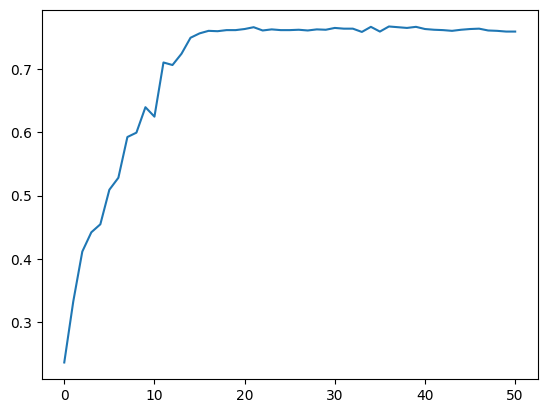

In [20]:
plt.plot(acc)